# MALA sampling of MLP weights using iris data

Sampling the weights of a multi-layer perceptron (MLP) using the iris data and MALA.

In [1]:
## Import packages

import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.distributions import Normal

from eeyore.api import indexify
from eeyore.data import Iris
from eeyore.models import mlp
from eeyore.mcmc import MALA

from timeit import default_timer as timer
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Avoid issuing memory warning due to number of plots

plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
## Load iris data

iris = indexify(Iris)()
dataloader = DataLoader(iris, batch_size=150, shuffle=True)

In [4]:
## Setup MLP model

hparams = mlp.Hyperparameters(dims=[4, 3, 3], activations=[torch.sigmoid, None])
model = mlp.MLP(
    hparams=hparams,
    loss=lambda x, y: nn.CrossEntropyLoss(reduction='sum')(x, torch.argmax(y, 1)),
    dtype=torch.float64
)
model.prior = Normal(
    torch.zeros(model.num_params(), dtype=model.dtype),
    np.sqrt(3)*torch.ones(model.num_params(), dtype=model.dtype)
)

In [5]:
## Setup MALA sampler

theta0 = model.prior.sample()
sampler = MALA(model, theta0, dataloader, step=0.0023)

In [6]:
## Run MALA sampler

start_time = timer()

sampler.run(num_iterations=11000, num_burnin=1000)

end_time = timer()
print("Time taken: {}".format(timedelta(seconds=end_time-start_time)))

Time taken: 0:00:19.948732


In [7]:
## Compute acceptance rate

sampler.chain.acceptance_rate()

0.5303999781608582

In [8]:
## Compute Monte Carlo mean

sampler.chain.mean()

tensor([ 1.5464,  1.1297,  0.7568,  1.5517, -0.6002, -1.8074,  1.3963,  1.8673,
         1.9826,  0.5610, -1.2662, -1.5325,  0.8686,  1.7026,  0.0540,  1.1817,
        -4.6346,  1.9592, -2.1340,  2.3724,  2.3366, -0.1222,  7.0162, -2.7317,
         0.9612,  1.2717, -1.3861], dtype=torch.float64)

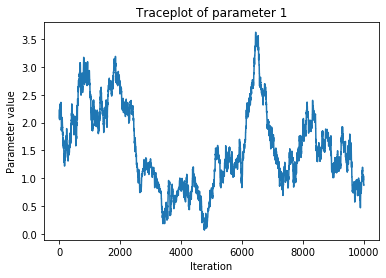

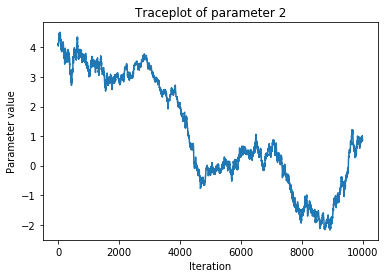

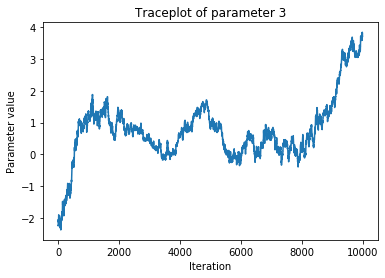

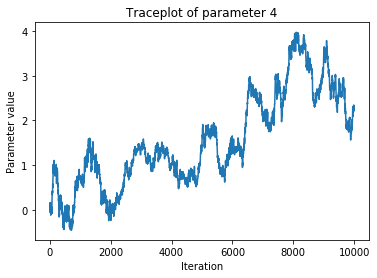

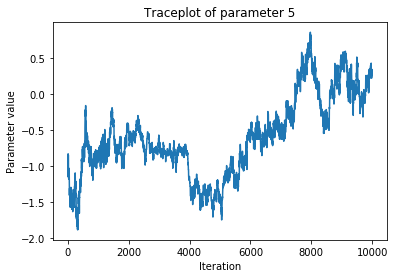

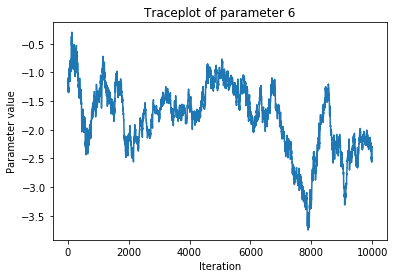

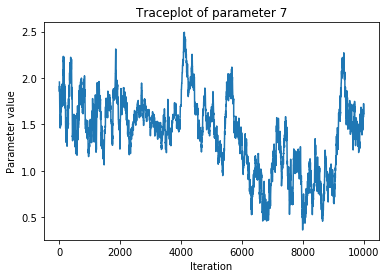

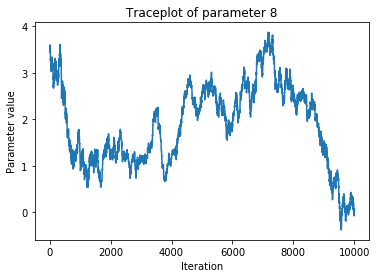

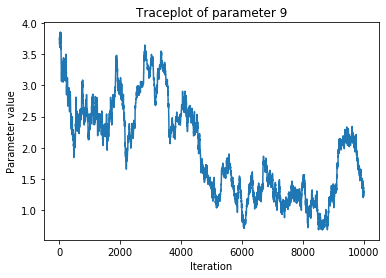

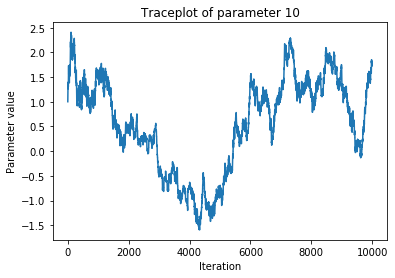

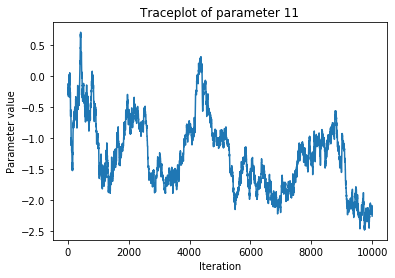

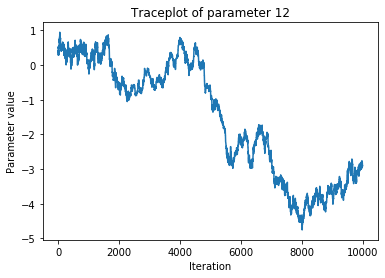

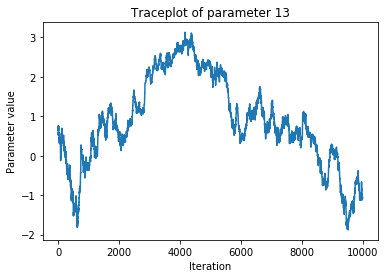

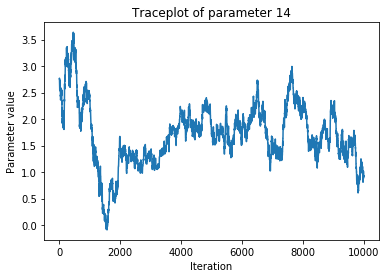

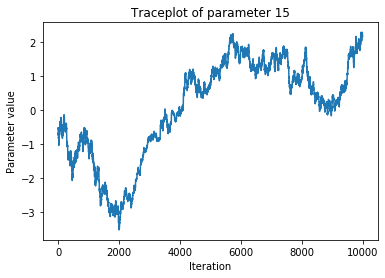

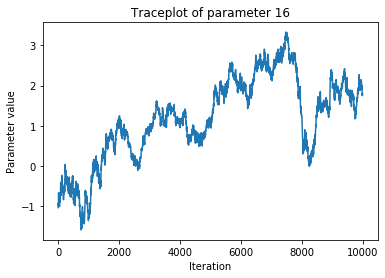

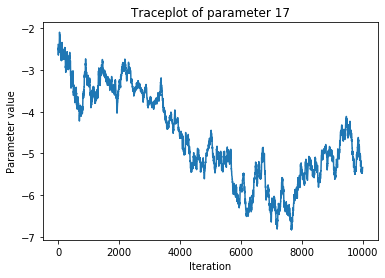

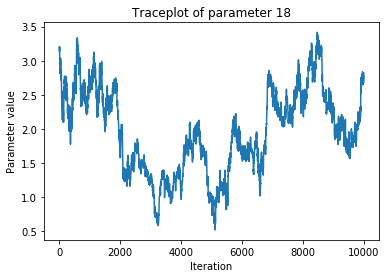

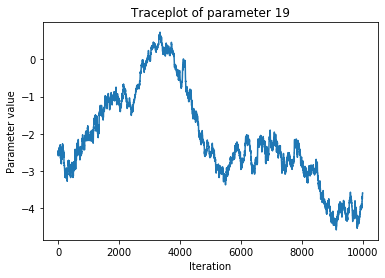

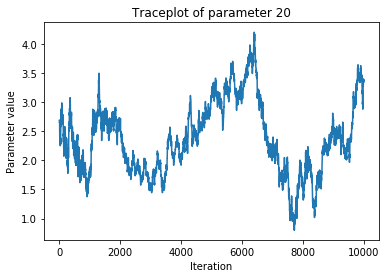

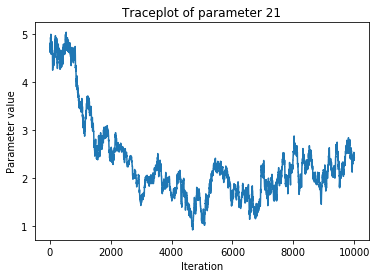

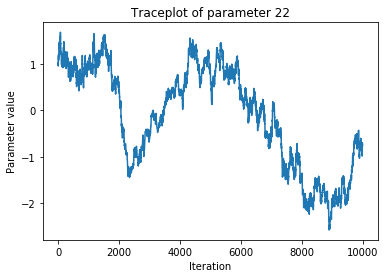

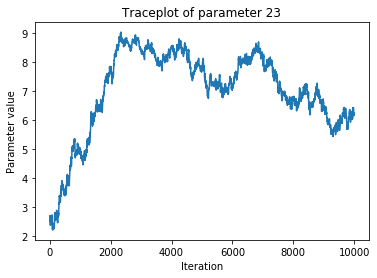

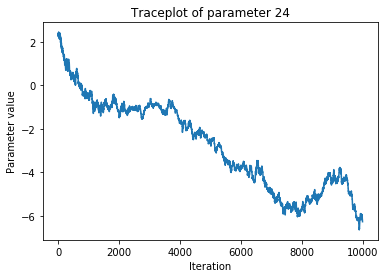

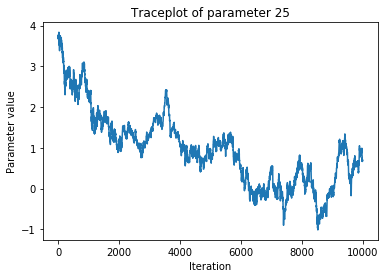

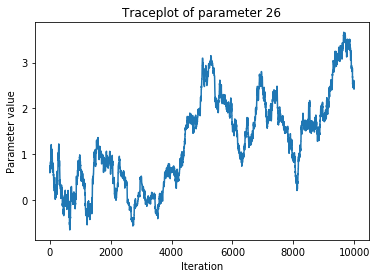

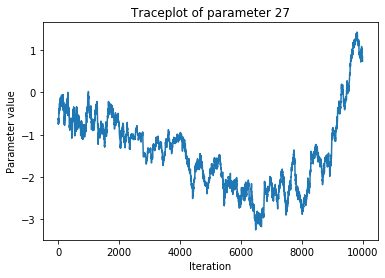

In [9]:
## Plot traces of simulated Markov chain

for i in range(model.num_params()):
    chain = sampler.chain.get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter {}'.format(i+1))

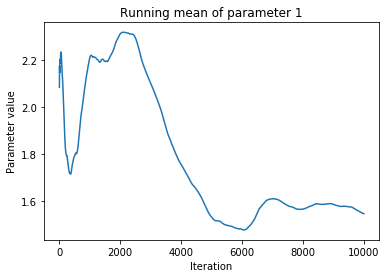

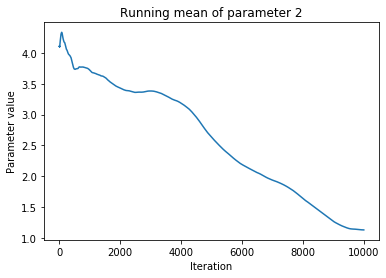

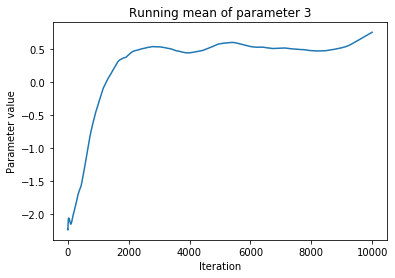

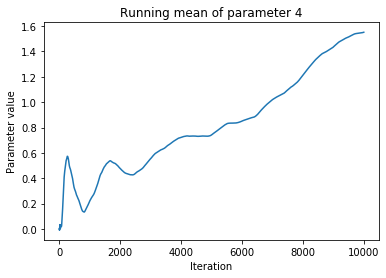

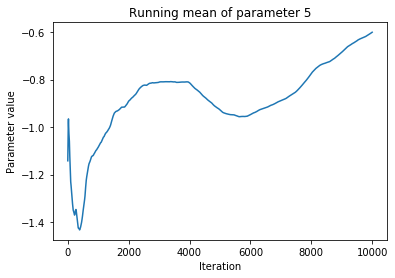

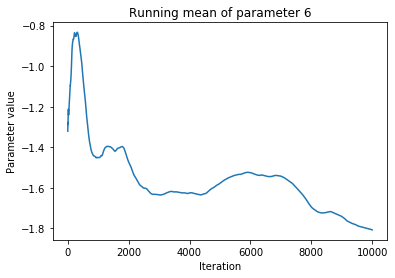

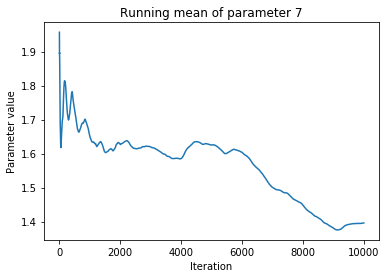

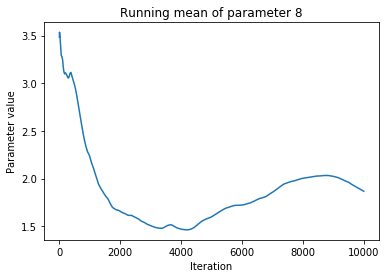

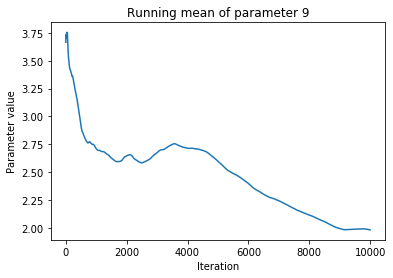

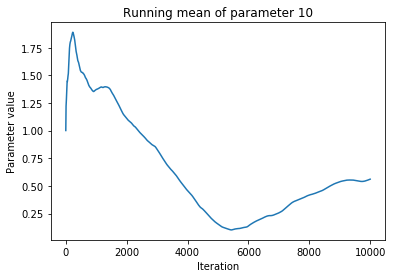

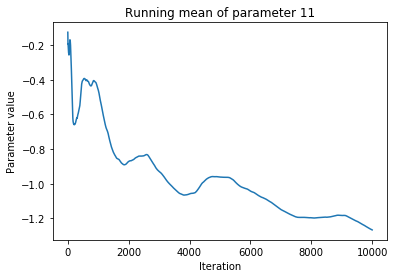

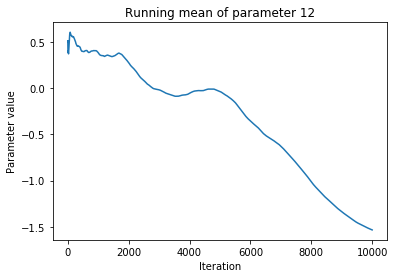

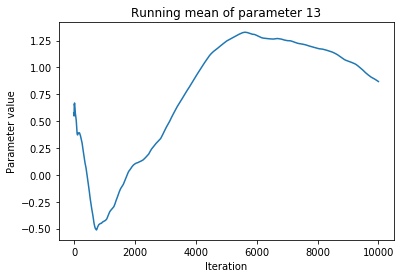

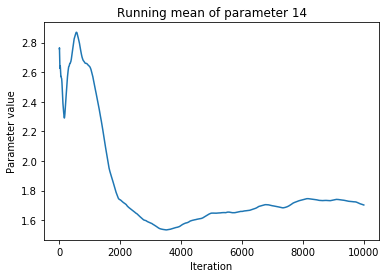

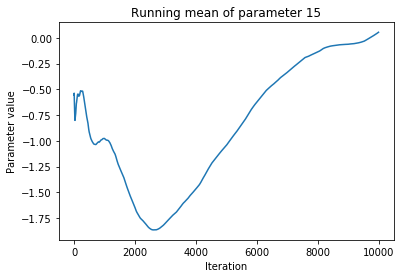

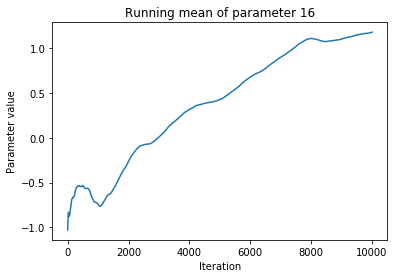

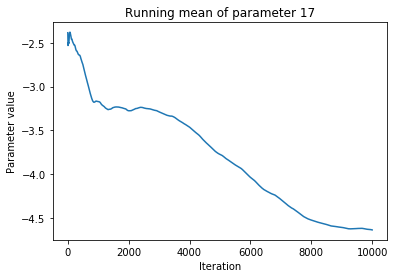

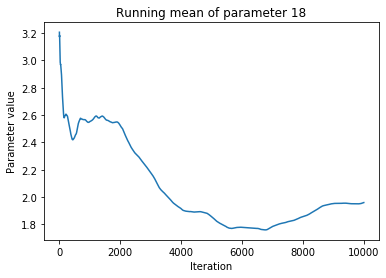

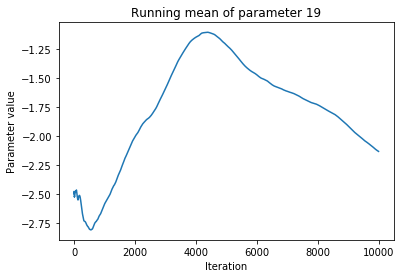

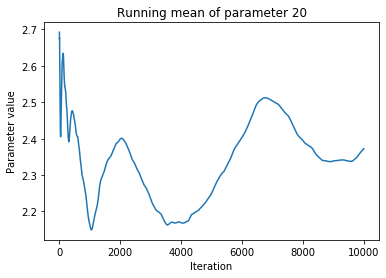

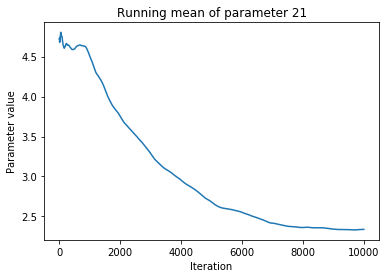

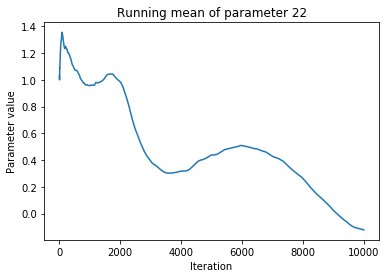

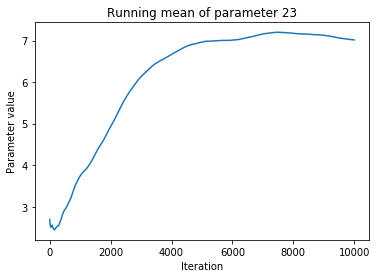

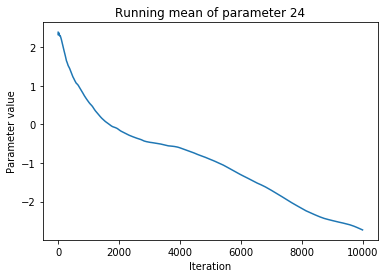

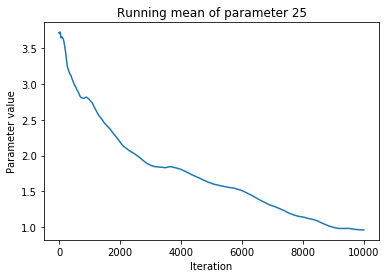

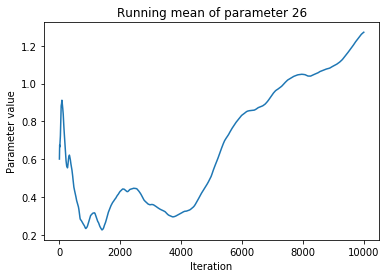

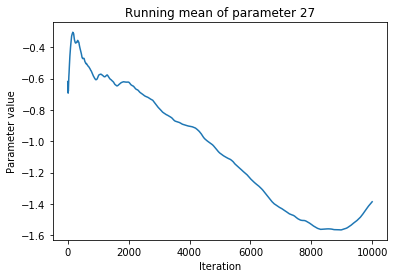

In [10]:
## Plot running means of simulated Markov chain

for i in range(model.num_params()):
    chain = sampler.chain.get_theta(i)
    chain_mean = torch.empty(len(chain))
    chain_mean[0] = chain[0]
    for j in range(1, len(chain)):
        chain_mean[j] = (chain[j]+j*chain_mean[j-1])/(j+1)
        
    plt.figure()
    sns.lineplot(range(len(chain)), chain_mean)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Running mean of parameter {}'.format(i+1))

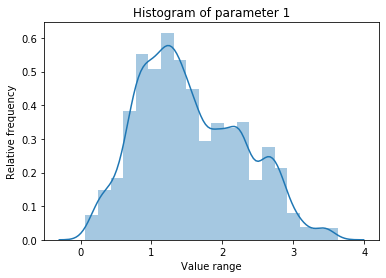

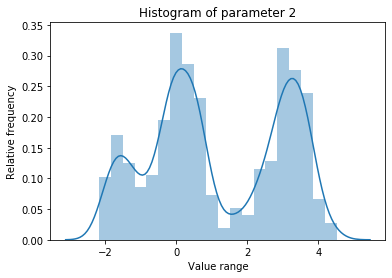

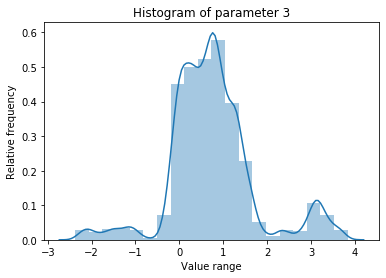

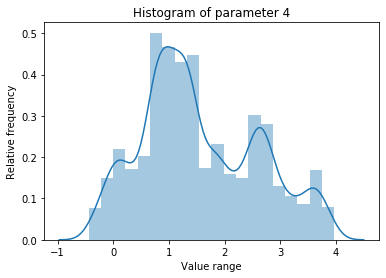

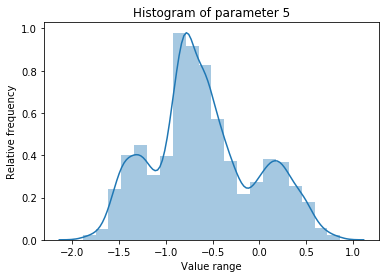

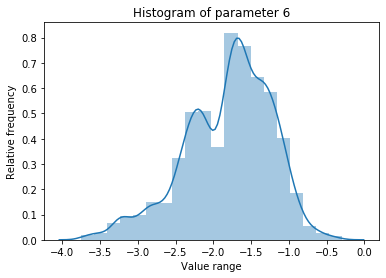

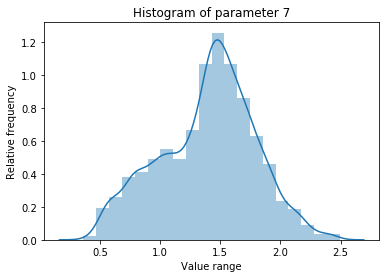

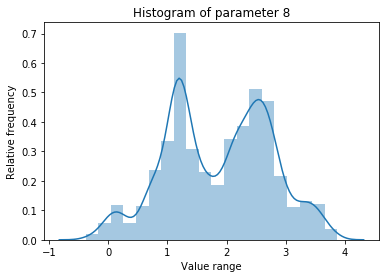

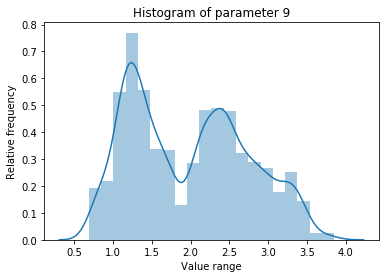

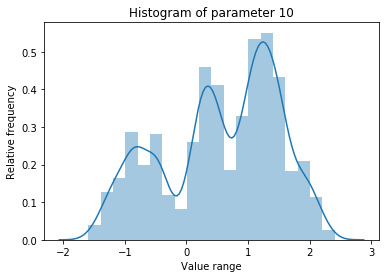

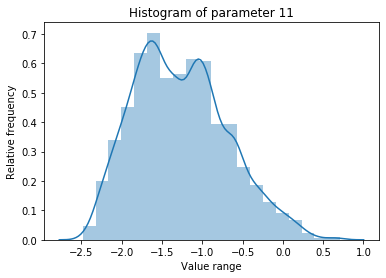

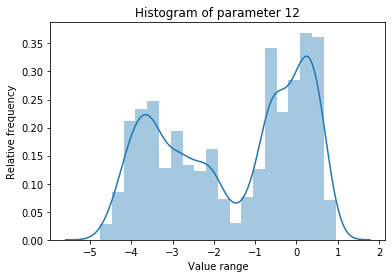

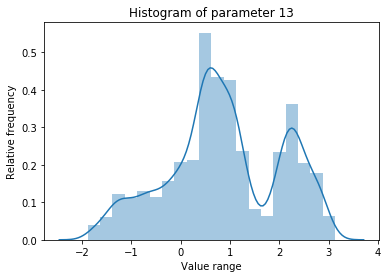

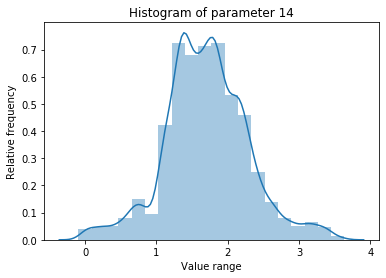

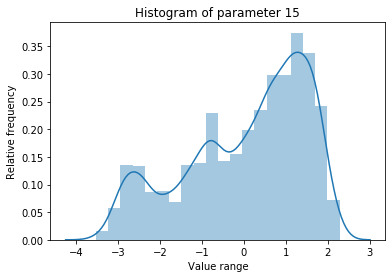

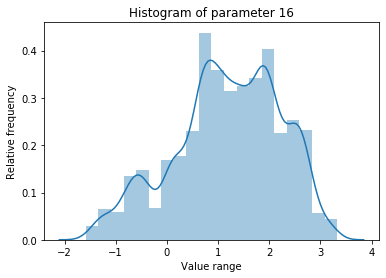

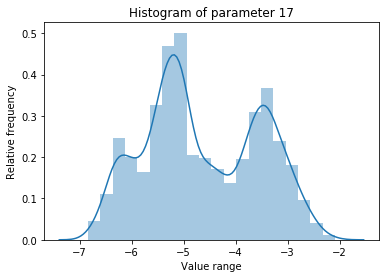

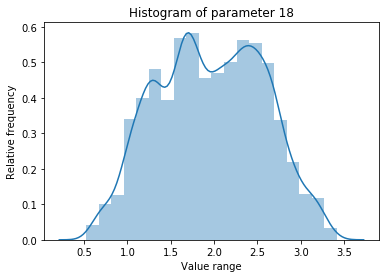

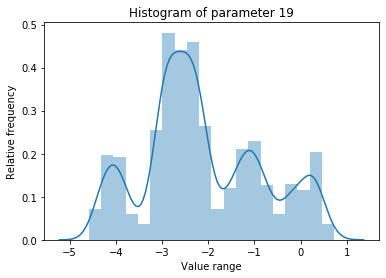

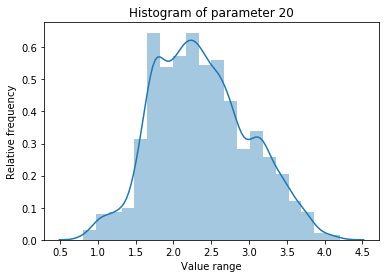

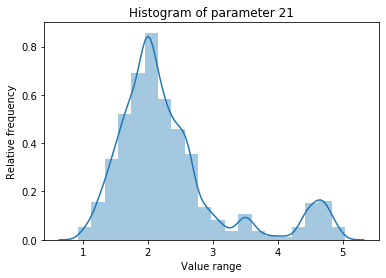

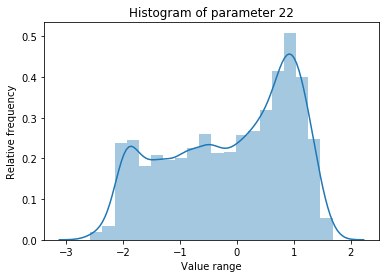

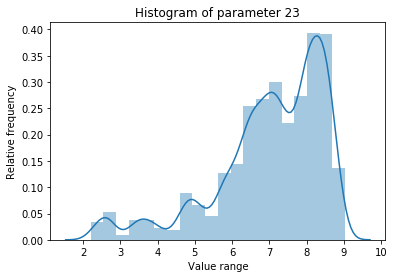

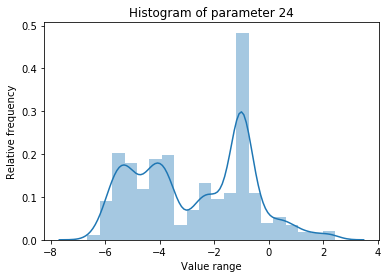

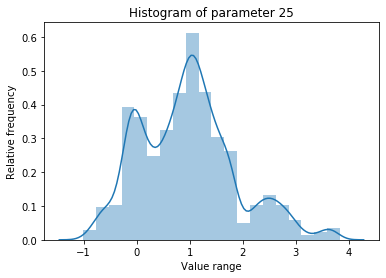

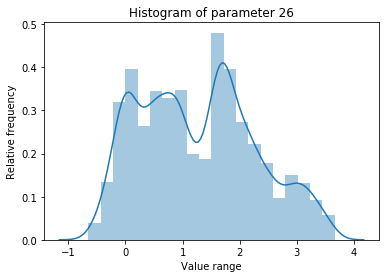

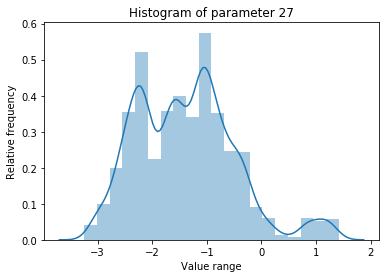

In [11]:
## Plot histograms of simulated Markov chain

for i in range(model.num_params()):
    plt.figure()
    sns.distplot(sampler.chain.get_theta(i), bins=20, norm_hist=True)
    plt.xlabel('Value range')
    plt.ylabel('Relative frequency')
    plt.title(r'Histogram of parameter {}'.format(i+1))

In [12]:
## Compute Monte Carlo approximation of posterior predictive distribution on sampled data points

# start_time = timer()

# predictive_samples, indices = model.predictive_posterior_sample(10, iris, sampler.chain)

# end_time = timer()
# print("Time taken: {}".format(timedelta(seconds=end_time-start_time)))